In [1]:
import glob, os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import json

In [2]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import CenterCrop

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import time

from sklearn.metrics import mean_absolute_percentage_error

import math

In [3]:
# !pip install -q -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

## Data preparation

In [4]:
def get_annotations(path):
	with open(path, 'r') as f:
		data = json.load(f)
	annot = []
	image_names=[]
	for image in data.keys():
		annot.append(len(data[image]['regions']))
		image_names.append(data[image]['filename'])
	return pd.DataFrame(data=annot, index=image_names, columns=["rod_number"])

In [5]:
train_data = get_annotations("segmentation_dataset/train_data/train_labels.json")
test_data = get_annotations("segmentation_dataset/test_data/test_labels.json")

In [6]:
print("Train labels: ", len(train_data))
print("Test labels: ", len(test_data))

Train labels:  4573
Test labels:  19


In [7]:
train_data

,rod_number
Photo (2)_0.JPG,27
Photo (2)_1.JPG,7
Photo (2)_2.JPG,20
Photo (2)_3.JPG,10
Photo (2)_4.JPG,11
...,...
Photo (315)_11.JPG,0
Photo (315)_12.JPG,0
Photo (315)_13.JPG,0
Photo (315)_14.JPG,0


In [8]:
train_data.describe()

,rod_number
count,4573.000000
mean,23.399738
std,39.966032
min,0.000000
25%,0.000000
50%,5.000000
75%,34.000000
max,637.000000


In [9]:
test_data.describe()

,rod_number
count,19.000000
mean,435.736842
std,278.146612
min,105.000000
25%,285.500000
50%,393.000000
75%,517.000000
max,1200.000000


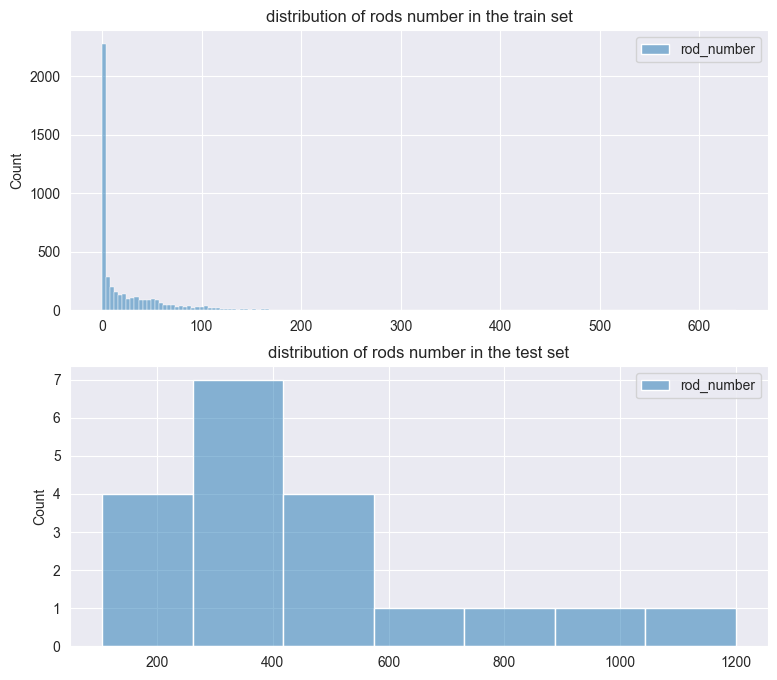

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.title("distribution of rods number in the train set")
sns.histplot(train_data);
plt.subplot(2,1,2)
plt.title("distribution of rods number in the test set")
sns.histplot(test_data);
plt.show();
plt.tight_layout()

We see that in the test images we have twice as much rods as in train. And in train set we have positively skewed distribution.

# Data preparation

In [11]:
IMAGE_TRAIN_DIR = "segmentation_dataset/train_data"
MASKS_TRAIN_DIR = "segmentation_dataset/train_masks"

IMAGE_TEST_DIR = "segmentation_dataset/test_data/"
# MASKS_TEST_DIR = "segmentation_dataset/test_masks/"

annot_train = "segmentation_dataset/train_data/train_labels.json"
annot_test = "segmentation_dataset/test_data/test_labels.json"

In the train set we have images 256X256, but in test set we have high resolution images of size 4160X3120. That's why in test images I will draw bigger circles according

In [12]:
train_radius = 10
test_radius = 20

In [13]:
def create_masks(images_dir, masks_dir, annotation_file, radius):
	'''
	function which creates masks same size as original images from images_dir
	and draws circles in the specified coordinates from annotation_file
	all images are saved in the masks_dir
	radius - radius of circles
	'''

	color = 1
	radius = radius
	thickness = -1

	with open(annotation_file, 'r') as f:
		data = json.load(f)

	for image in data.keys():
		image_name = data[image]['filename']
		file_name = os.path.join(images_dir, image_name)
		original_image = cv2.imread(file_name, 1)
		mask = np.zeros(original_image.shape[:2], dtype='uint8')

		if len(data[image]['regions'])>0:
			for idx in range(len(data[image]['regions'])):

				region = data[image]['regions'][str(idx)]

				cx = int(region["shape_attributes"]['cx'])
				cy = int(region["shape_attributes"]['cy'])



				mask = cv2.circle(mask, (cx, cy), radius, color, thickness)
				#mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

		output_name = os.path.join(masks_dir, str.lower(image_name).replace(".jpg",".npy"))
		#cv2.imwrite(output_name, mask)
		np.save(output_name, mask)



I have original images 3120 X 4160. To make patches I will divide image into patches 312 X 416.

In [63]:
def create_test_patches(images_dir, patches_dir, masks_dir, annotation_file, radius):
	'''
	function which creates masks same size as original images from images_dir
	and draws circles in the specified coordinates from annotation_file
	all images are saved in the masks_dir
	radius - radius of circles
	'''

	y_annot = [] #vector of the number of rods in new patch dataset

	color = 1
	radius = radius
	thickness = -1

	with open(annotation_file, 'r') as f:
		data = json.load(f)

	for image in data.keys():
		cx_list=[]
		cy_list=[]
		image_name = data[image]['filename']
		file_name = os.path.join(images_dir, image_name)
		original_image = cv2.imread(file_name, 1)
		#padd image to the size 3328 X 4352 to be devisible by 256

		#padded_image = cv2.copyMakeBorder(original_image, 0, 208, 0, 192, cv2.BORDER_CONSTANT, value=0)


		mask = np.zeros(original_image.shape[:2], dtype='uint8')

		if len(data[image]['regions'])>0:
			for idx in range(len(data[image]['regions'])):

				region = data[image]['regions'][str(idx)]

				cx = int(region["shape_attributes"]['cx'])
				cy = int(region["shape_attributes"]['cy'])

				#for counting the number of rods in each patch
				cx_list.append(cx)
				cy_list.append(cy)

				mask = cv2.circle(mask, (cx, cy), radius, color, thickness, cv2.FILLED)

		#create patches
		for j in range(0,10): #height = 312*10
			for i in range(0,10): #width = 416*10

				num_rods=0 #number of rods in that patch
				image_patch = original_image[j*312:(j+1)*312, i*416:(i+1)*416, :]

				#save image patch
				output_name = os.path.join(patches_dir, str.lower(image_name).replace(".jpg",f"_patch_{j}_{i}.jpg"))
				cv2.imwrite(output_name, image_patch)

				mask_patch = mask[j*312:(j+1)*312, i*416:(i+1)*416]
				#draw circles that get to that patch
				for (cx, cy) in zip(cx_list, cy_list):

					if (cx in range(i*416,(i+1)*416)) and (cy in range(j*312,(j+1)*312)):

						#increase number of blobs for that patch
						num_rods+=1

				#save mask
				#mask_patch = cv2.cvtColor(mask_patch, cv2.COLOR_BGR2GRAY)
				output_name = os.path.join(masks_dir, str.lower(image_name).replace(".jpg",f"_patch_{j}_{i}.npy"))
				#cv2.imwrite(output_name, mask_patch)
				#save mask patch as numpy array
				np.save(output_name, mask_patch)

				#save number of rods in y_annot
				y_annot.append(num_rods)

	return y_annot





In [519]:
#create masks for train
create_masks(IMAGE_TRAIN_DIR, MASKS_TRAIN_DIR, annot_train, train_radius)

In [58]:
#create masks for test
# create_masks(IMAGE_TEST_DIR, MASKS_TEST_DIR, annot_test, test_radius)

In [64]:
IMAGES_PATCHES_DIR = "segmentation_dataset/test_patches_images"
MASKS_PATCHES_DIR = "segmentation_dataset/test_patches_masks"

In [65]:
#create image and mask patches for test
y_annot = create_test_patches(IMAGE_TEST_DIR, IMAGES_PATCHES_DIR, MASKS_PATCHES_DIR, annot_test, test_radius)

In [62]:
print(y_annot)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 3, 0, 0, 0, 0, 0, 1, 8, 9, 9, 6, 0, 0, 0, 0, 0, 0, 9, 9, 8, 10, 1, 0, 0, 0, 0, 0, 4, 5, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 8, 10, 8, 6, 0, 0, 0, 4, 0, 7, 11, 9, 11, 13, 9, 3, 0, 5, 2, 11, 9, 11, 12, 11, 10, 1, 0, 5, 0, 4, 7, 4, 3, 4, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 4, 3, 4, 4, 2, 0, 0, 0, 6, 4, 3, 4, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3, 2, 3, 5, 9, 0, 0, 4, 3, 3, 3, 3, 3, 7, 21, 2, 0, 2, 1, 4, 3, 3, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 14, 19, 16, 0, 0, 0, 0, 1, 0

Let's look at the distribution of rods number on our 96 first images

### Define Model parameters

In [14]:
#1 version - efficientnet-b0'
ENCODER = 'efficientnet-b0'
ENCODER_DEPTH = 5
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['rod']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

BATCH_SIZE = 16


# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
	encoder_depth=ENCODER_DEPTH,
    classes=len(CLASSES),
    activation=ACTIVATION,
)


In [15]:
#define preprocessing for the encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

### Prepare dataset

In [16]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms, preprocessing):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		self.preprocessing = preprocessing

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):

		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		maskPath = self.maskPaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		# image = np.array(Image.open(self.imagePath).convert("RGB"))
        # mask = np.array(Image.open(self.maskPaths[idx]).convert("L"), dtype=np.float32)
        # mask[mask == 255.0] = 1.0
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = np.load(maskPath)





		mask = np.expand_dims(mask, -1)
		mask = mask.astype('float32')
		#mask[mask > 0] = 1.0

		# mask[mask == 255.0] = 1.0




		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			# image = np.array(image).astype("float32")
			# mask = np.array(mask).astype("float32")
			augmentations=self.transforms(image=image, mask=mask)
			image = augmentations["image"]
			mask = augmentations["mask"]

			#mask[mask ==255] = 1.0

			#mask = np.expand_dims(mask, -1)





		if self.preprocessing is not None:
			image = np.array(image)
			mask = np.array(mask)
			# print(image.shape)
			# print(mask.shape)
			sample = self.preprocessing(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']




		#mask[mask<255]=0.0
		#mask[mask > 0.0] = 1.0



		return (image, mask)

In [66]:
def get_training_augmentation():
    train_transform = [

		A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
		A.VerticalFlip(p=0.5),
		# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
		# ToTensorV2(transpose_mask=True),


		# A.Sharpen(p=1),
		# A.RandomBrightnessContrast(p=1),

        #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        #A.RandomCrop(height=256, width=256, always_apply=True),


        # A.Perspective(p=0.5),

     #    A.OneOf(
     #        [
     #            A.CLAHE(p=1),
     #            A.RandomBrightness(p=1),
     #            A.RandomGamma(p=1),
     #        ],
     #        p=0.9,
     #    ),
	 #
     #    A.OneOf(
     #        [
     #            A.Sharpen(p=1),
     #            A.Blur(blur_limit=3, p=1),
     #            # A.MotionBlur(blur_limit=3, p=1),
     #        ],
     #        p=0.9,
     #    ),
	 #
     #    A.OneOf(
     #        [
     #            A.RandomContrast(p=1),
     #            A.HueSaturationValue(p=1),
     #        ],
     #        p=0.9,
     #    ),
      ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
		A.Resize(width=256, height=256),
		# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
		# ToTensorV2(transpose_mask=True),



    ]
    return A.Compose(val_transform)

def get_test_augmentation():
	"""Add paddings to make image shape divisible by 32"""
	test_transform = [
		A.PadIfNeeded(320, 416) #padd images to be devisible by 32
	]
	return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [67]:
# load the image and mask filepaths in a sorted manner
imageTrainPaths = sorted(list(glob.glob(IMAGE_TRAIN_DIR+"/*.JPG")))
maskTrainPaths = sorted(list(glob.glob(MASKS_TRAIN_DIR+"/*.npy")))

imageTestPaths = sorted(list(glob.glob(IMAGES_PATCHES_DIR+"/*.jpg")))
maskTestPaths = sorted(list(glob.glob(MASKS_PATCHES_DIR+"/*.npy")))

In [68]:
len(imageTrainPaths)

4573

In [69]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for validation
split = train_test_split(imageTrainPaths, maskTrainPaths, test_size=0.2, random_state=42)
# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

In [24]:
len(trainImages)

3658

In [25]:
len(valImages)

915

In [26]:
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
							  transforms=get_training_augmentation(),
							  preprocessing=get_preprocessing(preprocessing_fn))

valDS = SegmentationDataset(imagePaths=valImages, maskPaths=valMasks,
							transforms=get_validation_augmentation(),
							preprocessing=get_preprocessing(preprocessing_fn))


print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the validation set...")

[INFO] found 3658 examples in the training set...
[INFO] found 915 examples in the validation set...


In [27]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE)
valLoader = DataLoader(valDS, shuffle=False, batch_size=BATCH_SIZE)

In [28]:
len(trainLoader)

229

In [545]:
def show_images_and_masks(loader):
	images, masks = next(iter(loader))
	for (image, mask) in zip(images, masks):
		image = image.permute(1, 2, 0)
		mask = mask.permute(1, 2, 0)
		plt.figure(figsize=(9,8))
		plt.subplot(1, 2, 1)
		plt.imshow(image)
		plt.title("Image")
		plt.subplot(1, 2, 2)
		plt.imshow(mask, cmap="gray")
		plt.title("Mask")
		plt.axis("off")
		plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


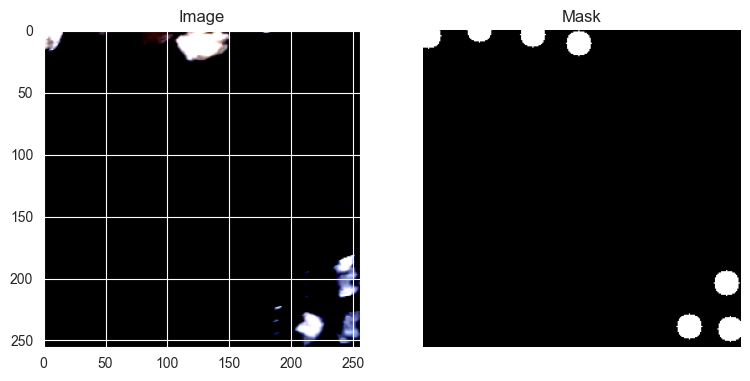

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


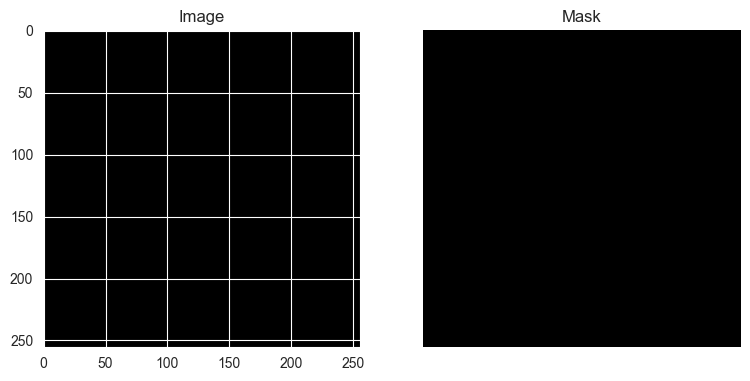

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


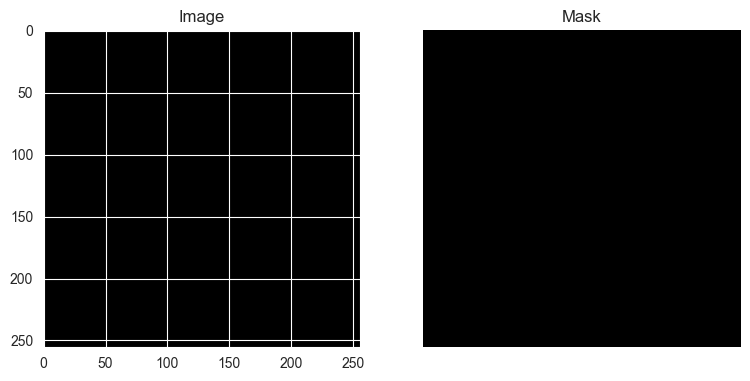

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


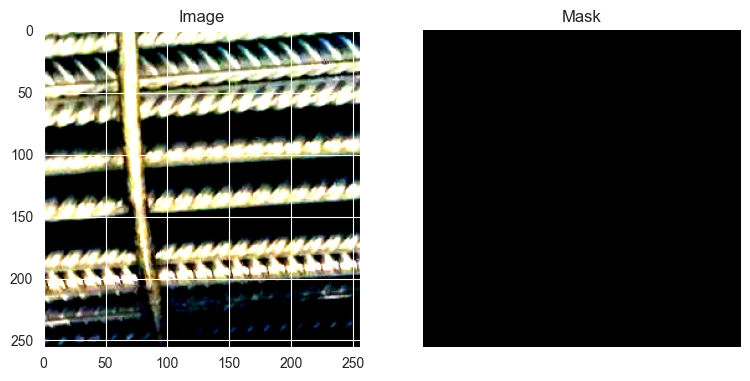

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


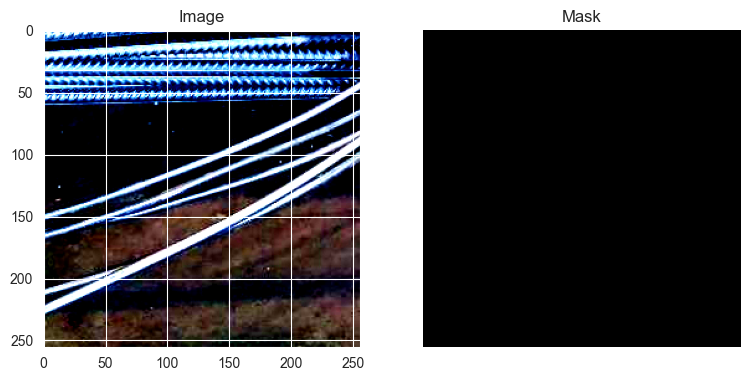

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


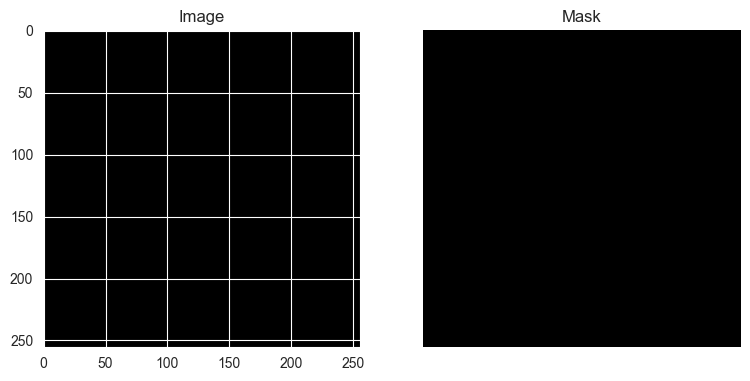

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


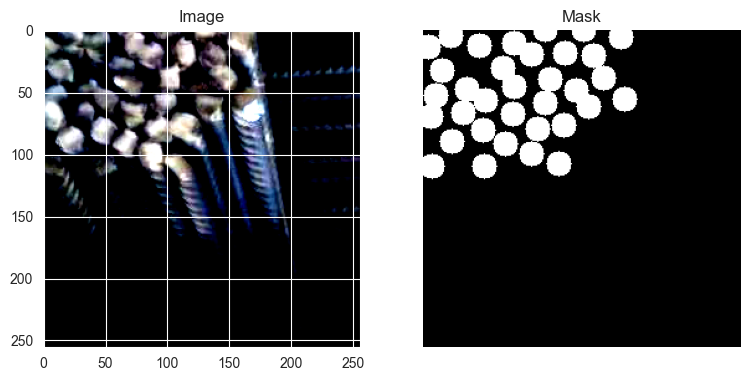

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


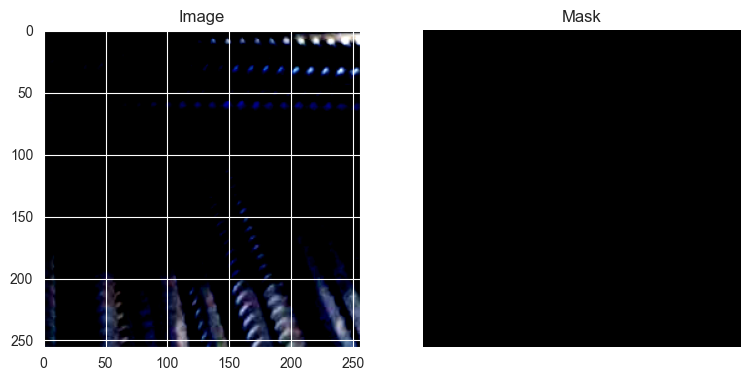

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


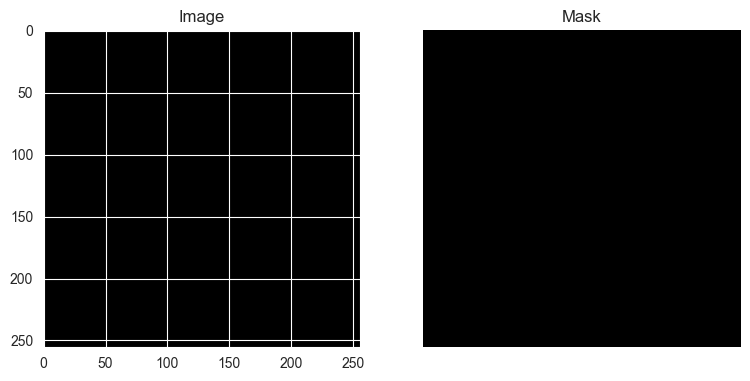

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


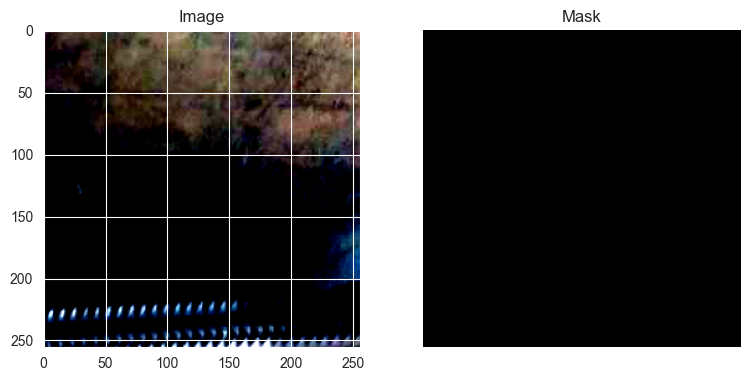

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


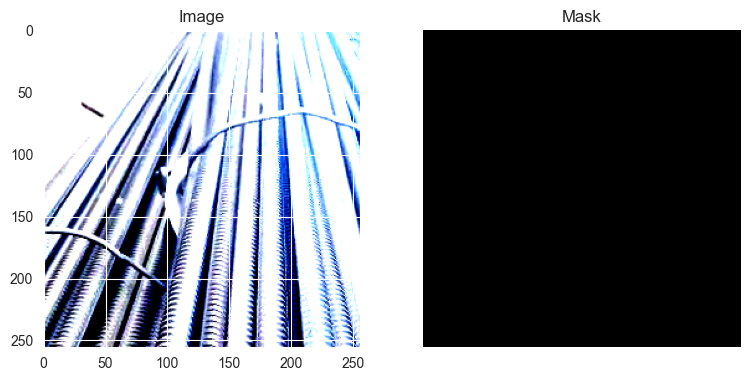

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


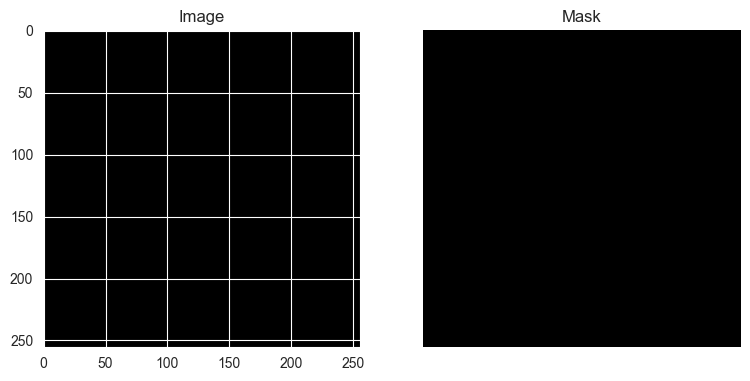

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


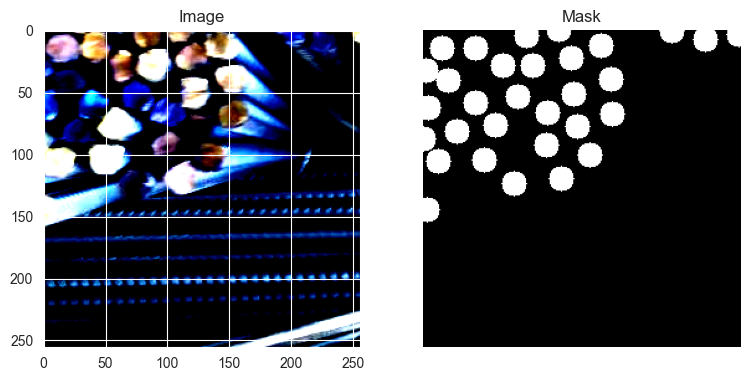

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


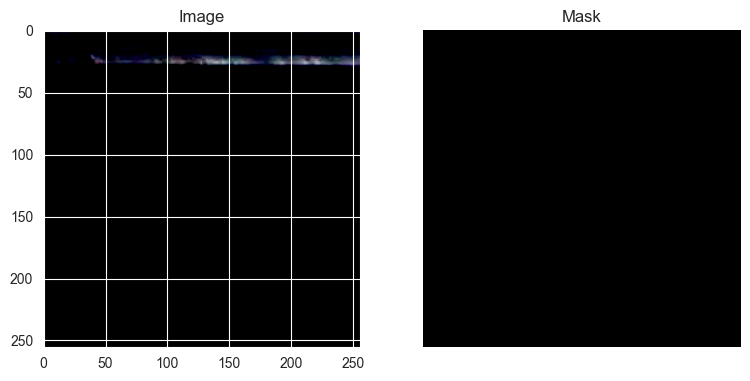

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


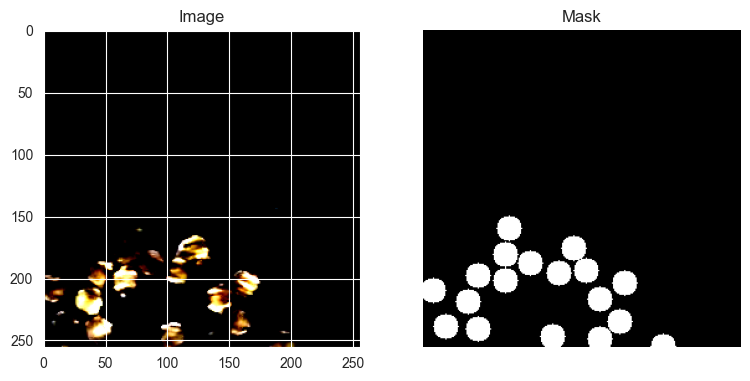

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


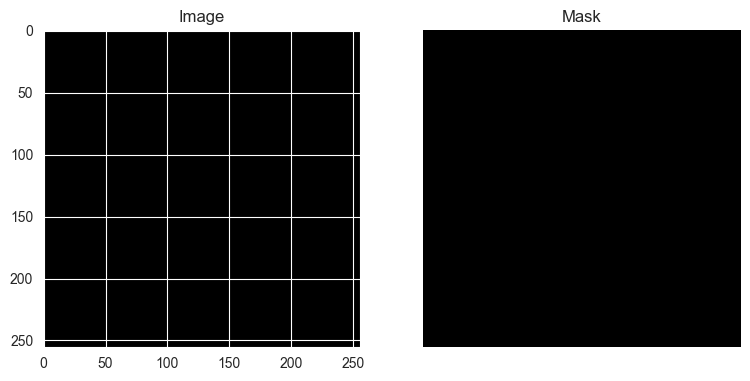

In [546]:
show_images_and_masks(trainLoader)

### Train model

### Define focal loss

In [33]:
ALPHA = 0.25
GAMMA = 2

class FocalLoss(nn.Module):
	def __init__(self, weight=None, size_average=True):
		super(FocalLoss, self).__init__()
		self.__name__ = "focal_loss"


	def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
		inputs = inputs.view(-1)
		targets = targets.view(-1)

        #first compute binary cross-entropy
		BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
		BCE_EXP = torch.exp(-BCE)
		focal_loss = alpha * (1-BCE_EXP)**gamma * BCE

		return focal_loss

In [34]:
# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
#loss = smp.utils.losses.BCEWithLogitsLoss(pos_weight=torch.tensor(100.))

loss = FocalLoss()

#loss = smp.utils.losses.DiceLoss()

metrics = [
	smp.utils.metrics.IoU(threshold=0.5),
	smp.utils.metrics.Accuracy(threshold=0.5)
]

# define optimizer
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

lr_min = 0.00001
lr_max = 0.001

#define learning rate scheduler (not used in this NB)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# )

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('output/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [549]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,

)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [550]:
MODEL_DIR = "output/version3"
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

	# Perform training & validation
	print('\nEpoch: {}'.format(i))
	train_logs = train_epoch.run(trainLoader)
	valid_logs = valid_epoch.run(valLoader)
	train_logs_list.append(train_logs)
	valid_logs_list.append(valid_logs)
	# Save model if a better val IoU score is obtained
	if best_iou_score < valid_logs['iou_score']:
		best_iou_score = valid_logs['iou_score']
		torch.save(model, f"{MODEL_DIR}/best_model.pth")
		print('Model saved!')

	print(f"Learning rate: {optimizer.param_groups[0]['lr']: .4f}")
	#change learning rate every epoch according to cos from lr_min to lr_max
	optimizer.param_groups[0]['lr'] = lr_min + 0.5*(lr_max - lr_min)*(1+math.cos((i+1)*math.pi/5))




Epoch: 0
valid: 100%|██████████| 58/58 [01:34<00:00,  1.63s/it, focal_loss - 0.007577, iou_score - 0.6449, accuracy - 0.9571]
Model saved!
Learning rate:  0.0001

Epoch: 1
valid: 100%|██████████| 58/58 [01:34<00:00,  1.63s/it, focal_loss - 0.0005396, iou_score - 0.7021, accuracy - 0.9682]
Model saved!
Learning rate:  0.0009

Epoch: 2
valid: 100%|██████████| 58/58 [01:35<00:00,  1.65s/it, focal_loss - 0.000316, iou_score - 0.7312, accuracy - 0.9711] 
Model saved!
Learning rate:  0.0007

Epoch: 3
valid: 100%|██████████| 58/58 [01:36<00:00,  1.66s/it, focal_loss - 0.0002804, iou_score - 0.7458, accuracy - 0.9714]
Model saved!
Learning rate:  0.0004

Epoch: 4
valid: 100%|██████████| 58/58 [01:34<00:00,  1.63s/it, focal_loss - 0.0002458, iou_score - 0.7493, accuracy - 0.9723]
Model saved!
Learning rate:  0.0001

Epoch: 5
valid: 100%|██████████| 58/58 [01:36<00:00,  1.67s/it, focal_loss - 0.0002462, iou_score - 0.7487, accuracy - 0.9723]
Learning rate:  0.0000

Epoch: 6
valid: 100%|████████

In [81]:
train_logs_list = pd.DataFrame.from_dict(train_logs_list)
valid_logs_list = pd.DataFrame.from_dict(valid_logs_list)

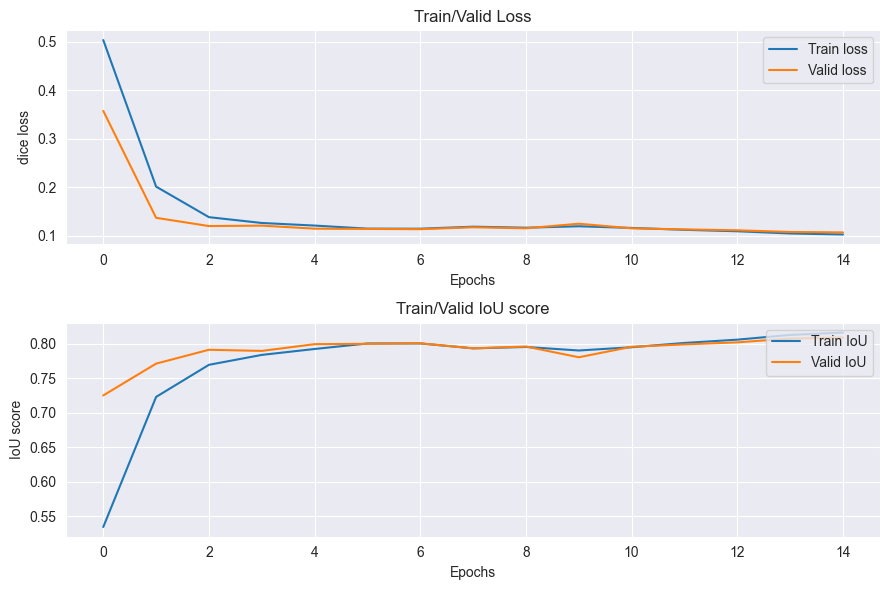

In [82]:
plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.plot(train_logs_list['dice_loss'], label="Train loss")
plt.plot(valid_logs_list['dice_loss'], label="Valid loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("dice loss")
plt.title("Train/Valid Loss")

plt.subplot(2,1,2)
plt.plot(train_logs_list['iou_score'], label="Train IoU")
plt.plot(valid_logs_list['iou_score'], label="Valid IoU")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("IoU score")
plt.title("Train/Valid IoU score")

plt.tight_layout()
plt.show()

### Load best model

In [29]:
# load best saved checkpoint
best_model = torch.load('output/version3/best_model.pth')

### Prepare patches for test

In [90]:
# create test dataset
testDS = SegmentationDataset(imagePaths=imageTestPaths, maskPaths=maskTestPaths,
							 transforms=get_test_augmentation(),
							 preprocessing=get_preprocessing(preprocessing_fn))

print(f"[INFO] found {len(testDS)} examples in the test set...")

testLoader = DataLoader(testDS, shuffle=False, batch_size=1)

[INFO] found 1900 examples in the test set...


In [85]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testLoader)

valid:   1%|▏         | 24/1900 [00:06<08:04,  3.87it/s, focal_loss - 1.273e-07, iou_score - 1.0, accuracy - 1.0]


KeyboardInterrupt: 

In [43]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	ax[0].axis("off")
	ax[1].axis("off")
	ax[2].axis("off")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()


### Blob detection

In [110]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = 1
params.blobColor = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 3
#
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
#
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
#
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
  detector = cv2.SimpleBlobDetector(params)
else :
  detector = cv2.SimpleBlobDetector_create(params)

In [101]:
def detect_blobs(image):
	keypoints = detector.detect(image)
	# Draw detected blobs as red circles.
	# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
	# im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
	#
	# # Show keypoints
	# plt.imshow(im_with_keypoints)
	# plt.axis("off")
	# plt.show()
	return len(keypoints)

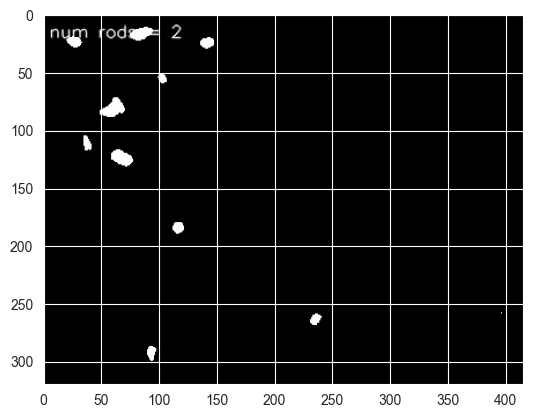

In [108]:
image = cv2.imread("segmentation_dataset/predictions/Prediction_1285.jpg")
plt.imshow(image)

In [109]:
print(detect_blobs(image))

10


In [38]:


#because of zeros in y_train_true we got very high MAPE on train
#print(f"MAPE: {mean_absolute_percentage_error(y_train_true, y_train_pred) :.2f}")

In [61]:
y_test_true = test_data[:len(y_test_pred)]['rod_number'].values

In [62]:
y_test_true

array([ 111,  288,  105,  283,  314,  393,  593,  427,  471,  359,  539,
        396,  375,  731,  495,  909,  156, 1200,  134], dtype=int64)

In [63]:
print(f"MAPE: {mean_absolute_percentage_error(y_test_true, y_test_pred) :.2f}")

MAPE: 0.90


### Show predictions

In [111]:
OUT_DIR = "segmentation_dataset/predictions"

font = cv2.FONT_HERSHEY_SIMPLEX
# org
org = (5, 20)
# fontScale
fontScale = 0.5
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 1

def make_predictions(testLoader, OUT_DIR):
	y_pred = []
	i=0

	for image, gt_mask in testLoader:




		image = image.squeeze().cpu().numpy()

		gt_mask = gt_mask.squeeze().cpu().numpy()
		gt_mask = 255*gt_mask.astype('uint8')
		x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

		pr_mask = best_model.predict(x_tensor)
		pr_mask = pr_mask.squeeze().cpu().numpy()
		pr_mask[pr_mask>=0.3]=1
		pr_mask = 255*pr_mask.astype('uint8')



		blobs_num = detect_blobs(pr_mask)

		y_pred.append(blobs_num)

		# Using cv2.putText() method
		pr_mask = cv2.putText(pr_mask, f"num rods = {str(blobs_num)}",
							org, font, fontScale, color, thickness, cv2.LINE_AA)


		cv2.imwrite(os.path.join(OUT_DIR, f"Prediction_{i}.jpg"), pr_mask)

		i+=1

	return y_pred
		# image = torch.from_numpy(image).permute(1, 2, 0).cpu().numpy()
		# prepare_plot(image, gt_mask, pr_mask)


In [ ]:
y_pred = make_predictions(testLoader, OUT_DIR)

In [89]:
y_pred

[0]

TypeError: Image data of dtype object cannot be converted to float

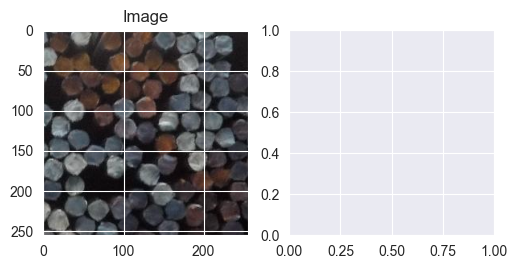

In [81]:
image = cv2.imread("segmentation_dataset/train_data/Photo (4)_6.JPG", cv2.COLOR_BGR2RGB)
gt_mask = cv2.imread("segmentation_dataset/train_masks/Photo (4)_6.JPG", 0)

plt.figure(figsize=(9,6))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(gt_mask)
plt.title("Mask")





image = torch.tensor(image).permute(2, 0, 1)

print(image.shape)
# gt_mask = gt_mask.squeeze().cpu().numpy()

x_tensor = image.to(DEVICE).unsqueeze(0).float()

pr_mask = best_model.predict(x_tensor)

pr_mask = 255*pr_mask.astype("uint8")

plt.subplot(1,3,3)
plt.imshow(pr_mask)
plt.title("Predicted Mask")

plt.show()

In [103]:
pr_mask

tensor([[[[1.2791e-03, 1.4787e-04, 1.6175e-04,  ..., 1.6473e-04,
           1.7879e-04, 4.2365e-03],
          [9.0906e-05, 3.7513e-06, 5.1453e-06,  ..., 5.3260e-06,
           2.1718e-06, 1.9604e-04],
          [6.7558e-05, 3.1794e-06, 5.3263e-06,  ..., 5.8671e-06,
           1.3184e-06, 8.7664e-05],
          ...,
          [5.5497e-05, 2.4334e-06, 3.5212e-06,  ..., 6.1540e-06,
           1.4025e-06, 1.2645e-04],
          [6.8681e-05, 2.0145e-06, 1.4595e-06,  ..., 3.7966e-06,
           9.4009e-07, 9.5420e-05],
          [2.0458e-03, 1.1490e-04, 5.2406e-05,  ..., 1.1914e-04,
           4.6431e-05, 1.4031e-03]]]], grad_fn=<SigmoidBackward0>)

In [98]:
pr_mask[pr_mask>=0.5]=1

In [99]:
pr_mask

tensor([[[[5.0517e-04, 7.6962e-06, 8.5824e-06,  ..., 2.3443e-05,
           4.1101e-05, 4.9557e-04],
          [3.1470e-05, 8.3562e-08, 1.0133e-07,  ..., 3.2980e-07,
           3.5277e-07, 1.0341e-05],
          [1.1296e-05, 5.8733e-08, 1.6489e-07,  ..., 2.6867e-07,
           1.5485e-07, 1.1604e-05],
          ...,
          [1.0059e-05, 5.0930e-08, 1.9463e-07,  ..., 6.4454e-08,
           6.8752e-08, 4.5786e-06],
          [1.4329e-05, 2.1223e-08, 5.6986e-08,  ..., 9.1744e-09,
           2.3888e-08, 2.7918e-06],
          [3.7204e-04, 5.7653e-06, 6.7717e-06,  ..., 1.4562e-06,
           4.9548e-06, 1.9534e-04]]]])

In [104]:
pr_mask.max()
pr_mask = 255*pr_mask.cpu().numpy().astype('uint8')

255

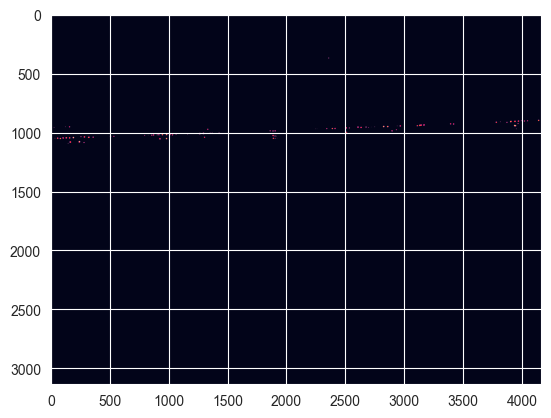

In [105]:
plt.imshow(pr_mask.squeeze())

In [90]:
def preprocess_image(image):

	# transforms = get_validation_augmentation()
	# sample = transforms(image = image)
	#
	# image = sample['image']

	preprocessing = get_preprocessing(preprocessing_fn)
	sample = preprocessing(image = image)

	image = sample['image']

	# image = image.astype("float32")
	# image = torch.from_numpy(image).permute(2,0,1)

	# image = (image - image.mean(0))/image.std(0)
	# image_tensor = image.unsqueeze(0)

	return image_tensor


In [91]:
image_tensor = preprocess_image(image)

In [92]:
image_tensor.shape

torch.Size([1, 3, 256, 256])

In [93]:
image_tensor

tensor([[[[-0.7559, -0.7559, -0.7559,  ..., -0.7559, -0.7559, -0.7559],
          [-0.7559, -0.7559, -0.7559,  ..., -0.7559, -0.7559, -0.7559],
          [-0.7559, -0.7559, -0.7559,  ..., -0.7559, -0.7559, -0.7559],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,     nan,     nan,     nan],
          [ 0.0000,  0.0000,  0.0000,  ...,     nan,     nan,     nan],
          [ 0.0000,  0.0000,  0.0000,  ...,     nan,     nan,     nan]],

         [[-0.3780, -0.3780, -0.3780,  ..., -0.3780, -0.3780, -0.3780],
          [-0.3780, -0.3780, -0.3780,  ..., -0.3780, -0.3780, -0.3780],
          [-0.3780, -0.3780, -0.3780,  ..., -0.3780, -0.3780, -0.3780],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,     nan,     nan,     nan],
          [-1.0000, -1.0000, -1.0000,  ...,     nan,     nan,     nan],
          [-1.0000, -1.0000, -1.0000,  ...,     nan,     nan,     nan]],

         [[ 1.1339,  1.1339,  1.1339,  ...,  1.1339,  1.1339,  1.1339],
          [ 1.1339,  1.1339,  

In [87]:
pr_mask = best_model.predict(image_tensor).squeeze()

In [88]:
pr_mask.shape

torch.Size([256, 256])

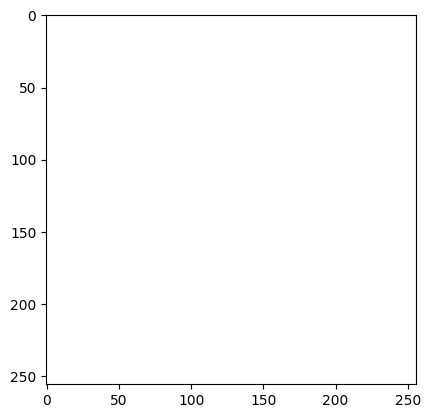

In [89]:
plt.imshow(pr_mask)

### My U-net model architecture

In [230]:
class Block(nn.Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3)
		self.relu = nn.ReLU()
		self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3)
		#self.batchnorm = nn.BatchNorm2d(outChannels)

	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		# x = self.conv1(x)
		# x = self.batchnorm(x)
		# x = self.relu(x)
		#
		# x = self.conv(x)
		# x = self.batchnorm(x)
		# x = self.relu(x)

		return self.conv2(self.relu(self.conv1(x)))

In [231]:
class Encoder(nn.Module):
	def __init__(self, channels=(3, 64, 128, 256, 512)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.bottleneck = Block(channels[-1], channels[-1]*2)


	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)

		x = self.bottleneck(x)
		# return the list containing the intermediate outputs
		return blockOutputs, x

In [234]:
class Decoder(nn.Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = nn.ModuleList(
			[nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		#do first upsampling from 1024 to 512 channels
		# x = nn.ConvTranspose2d(2*self.channels[0], self.channels[0], kernel_size=2, stride=2)
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [235]:
INPUT_IMAGE_HEIGHT = 256
INPUT_IMAGE_WIDTH = 256

In [236]:
class UNet(nn.Module):
	def __init__(self, encChannels=(3, 64, 128, 256, 512),
		 decChannels=(1024, 512, 256, 128, 64),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize


	def forward(self, x):
		# grab the features from the encoder
		encFeatures, x = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(x, encFeatures[::-1])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [237]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

### Training

In [98]:
# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

In [238]:
len(trainMasks)

3658

In [239]:
len(valImages)

915

In [241]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()

opt = torch.optim.Adam(unet.parameters(), lr=0.0001)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [313]:
EPOCHS = 20

MODEL_PATH = "output/version4/unet_model.pth"

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)


In [314]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
train_acc=[]
val_acc=[]
for e in tqdm(range(EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# loop over the training set
	num_correct = 0
	num_pixels = 0
	dice_score = 0
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		y = y.to(torch.float32).squeeze()

		# perform a forward pass and calculate the training loss
		pred = unet(x).squeeze().to(torch.float32)

		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss

		#compute metrics
		pred = torch.sigmoid(pred)
		pred =(pred > 0.5).float()
		num_correct += (pred == y).sum()
		num_pixels += torch.numel(pred)
		dice_score += (2 * (pred * y).sum())/((pred + y).sum() + 1e-8)

	print(f"Train accuracy: {num_correct/num_pixels:.2f} Dice score: {dice_score/len(trainLoader):.2f}")
	train_acc.append(num_correct / num_pixels)

	lr_scheduler.step()


	num_correct = 0
	num_pixels = 0
	dice_score = 0
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in valLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			y = y.to(torch.float32)
			# make the predictions and calculate the validation loss
			pred = unet(x).squeeze().to(torch.float32)
			totalValLoss += lossFunc(pred, y)

			#compute metrics
			pred = torch.sigmoid(pred)
			pred = (pred > 0.5).float()
			num_correct += (pred == y).sum()
			num_pixels += torch.numel(pred)
			dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)

	print(f"Val accuracy: {num_correct/num_pixels:.2f} Dice score: {dice_score/len(trainLoader):.2f}")

	val_acc.append(num_correct/num_pixels)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))

	torch.save({
            'epoch': e,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avgTrainLoss,
            }, MODEL_PATH)
	print("Model saved!")
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]

Train accuracy: 0.92 Dice score: 0.00


  0%|          | 0/20 [27:00<?, ?it/s]


ValueError: Target size (torch.Size([16, 1, 256, 256])) must be the same as input size (torch.Size([16, 256, 256]))

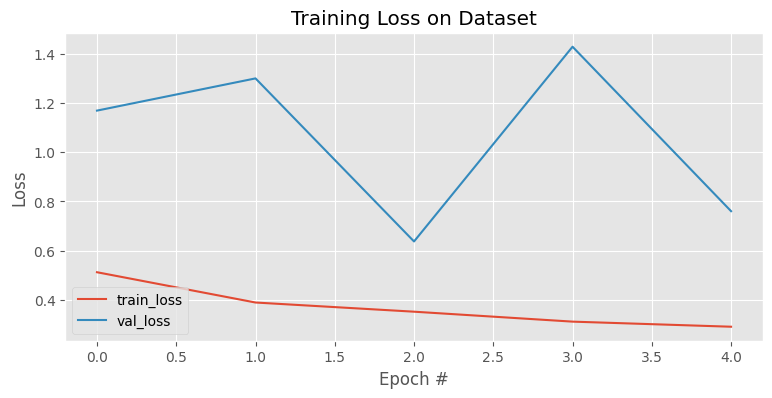

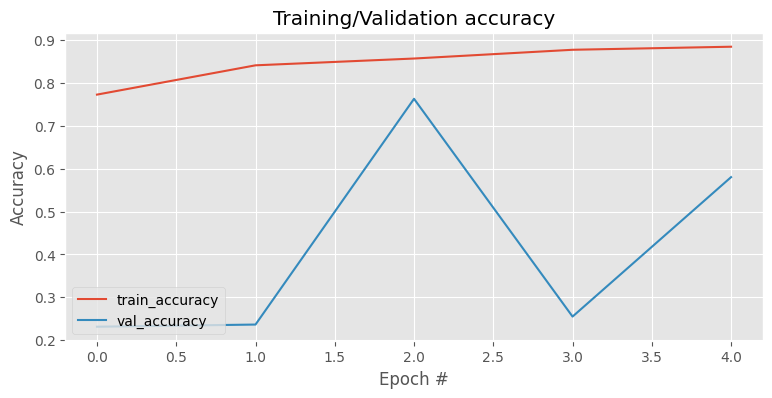

In [41]:
# plot the training loss
plt.style.use("ggplot")
plt.figure(figsize=(9, 4))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

plt.style.use("ggplot")
plt.figure(figsize=(9, 4))
plt.plot(range(len(train_acc)), train_acc, label="train_accuracy")
plt.plot(range(len(val_acc)), val_acc, label="val_accuracy")
plt.title("Training/Validation accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [42]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	ax[0].axis("off")
	ax[1].axis("off")
	ax[2].axis("off")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()


In [43]:
def make_predictions(loader, model, device=DEVICE):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            pred = torch.sigmoid(model(x))
            pred = (pred > 0.5).float()
            num_correct += (pred == y).sum()
            num_pixels += torch.numel(pred)
            dice_score += (2 * (pred * y).sum()) / (
                (pred + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")

In [44]:
make_predictions(testLoader, unet)

Got 479807/786432 with acc 61.01
Dice score: 0.08118806779384613


In [45]:
def plot_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
			# load the image from disk, swap its color channels, cast it
			# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



			# image =
			# image = image.astype("float32") / 255.0
			# # resize the image and make a copy of it for visualization
			# image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
		orig = image.copy()
			# find the filename and generate the path to ground truth
			# mask
		filename = (imagePath.split(os.path.sep)[-1].split(".")[0]+"_mask.jpg")
		groundTruthPath = os.path.join(TEST_MASKS,filename)
			# load the ground-truth segmentation mask in grayscale mode
			# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
			# gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))

		augmentations=val_transforms(image=image, mask=gtMask)
		image = augmentations["image"]
		gtMask = augmentations["mask"]

			# make the channel axis to be the leading one, add a batch
			# dimension, create a PyTorch tensor, and flash it to the
			# current device
			#image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
			# make the prediction, pass the results through the sigmoid
			# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
			# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
			# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

In [46]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

[INFO] load up model...


[INFO] loading up test image paths...


C:\Users\user\AppData\Local\Temp\ipykernel_5232\3150140407.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


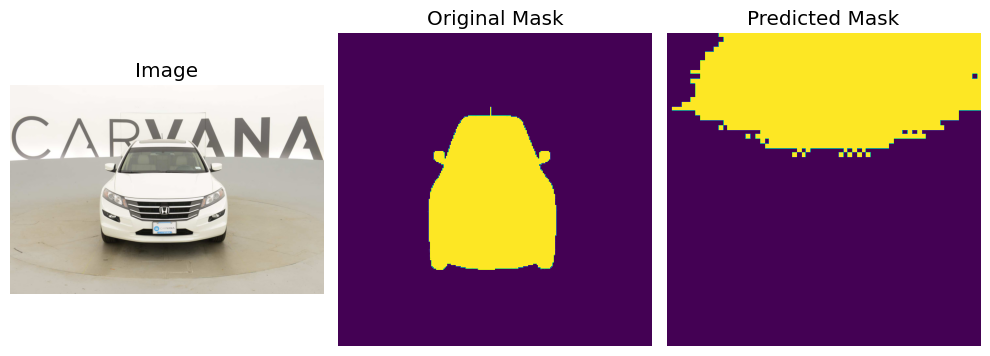

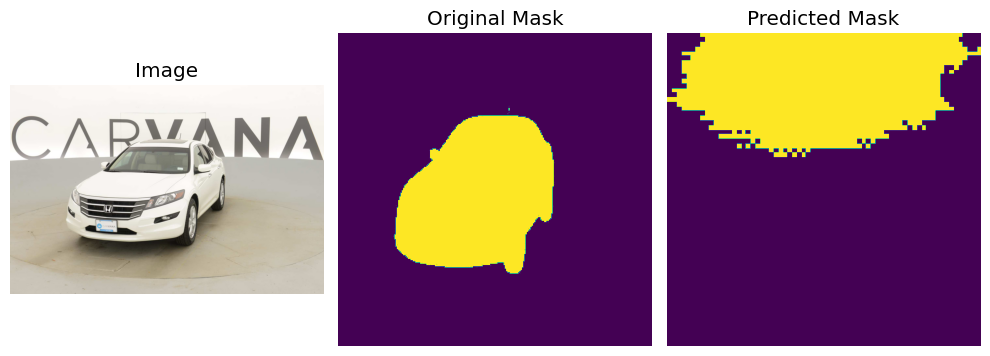

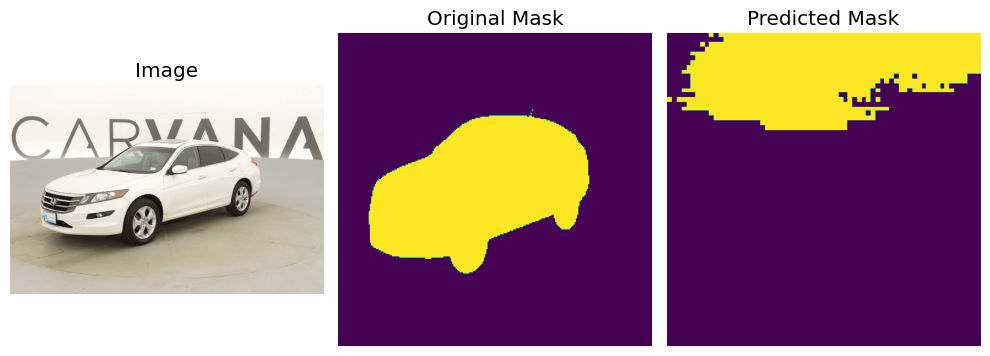

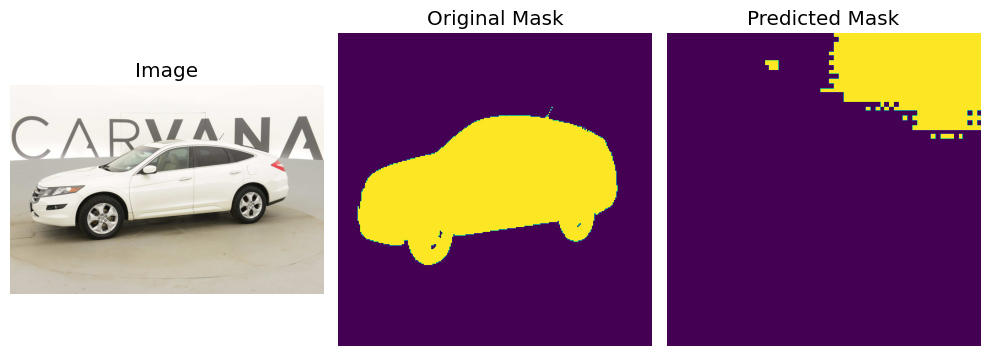

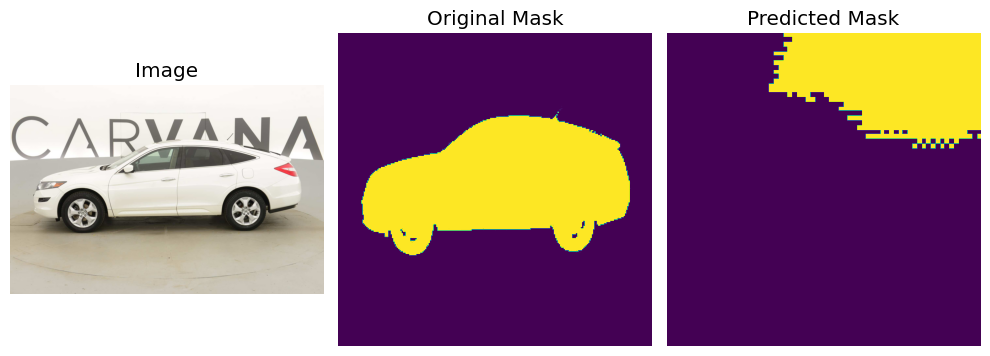

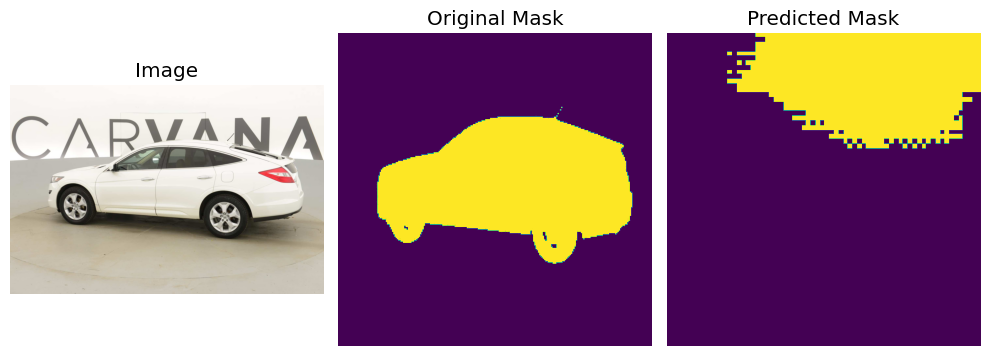

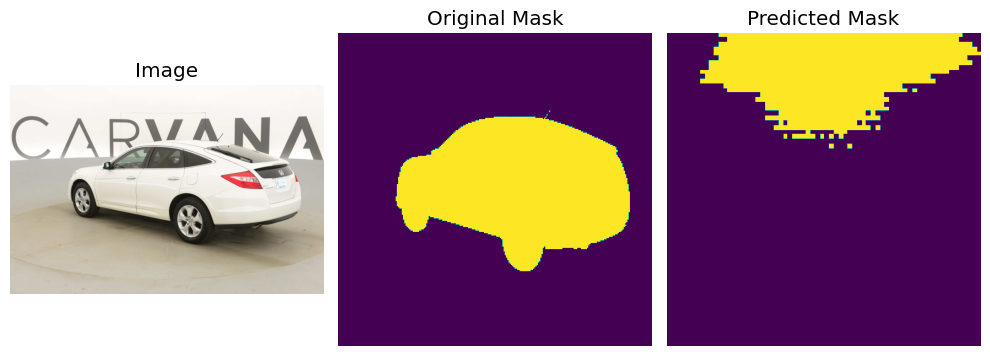

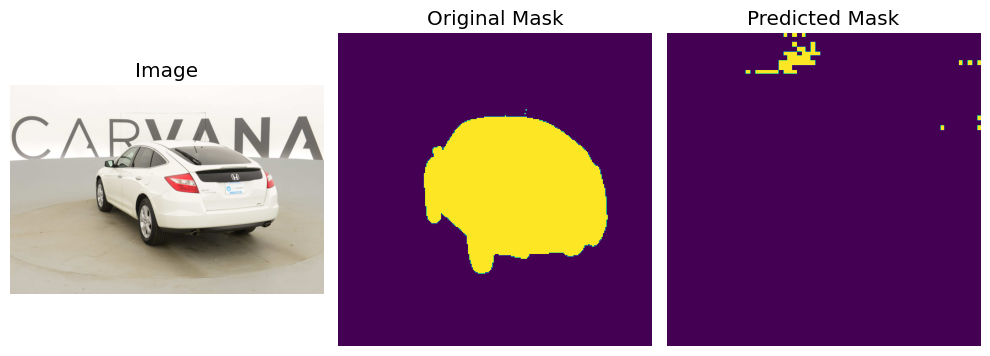

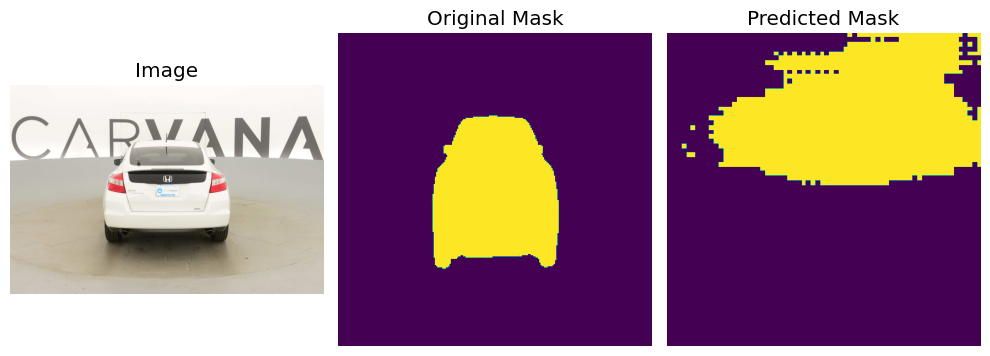

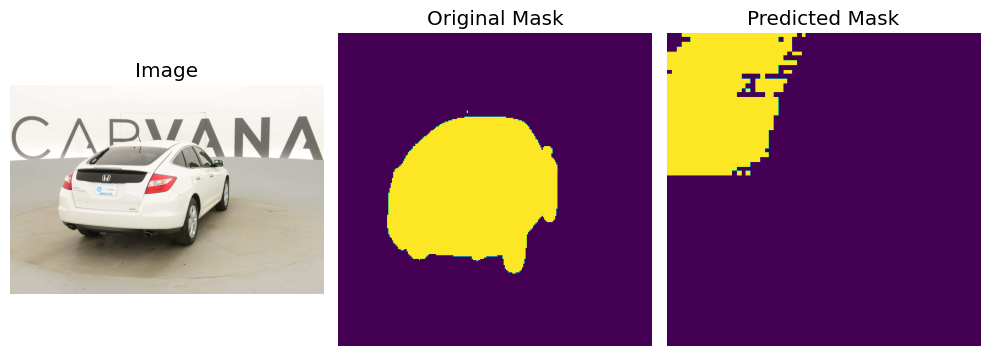

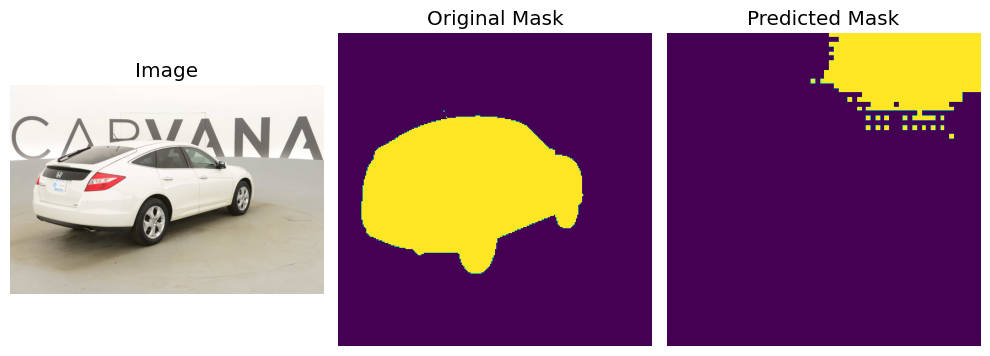

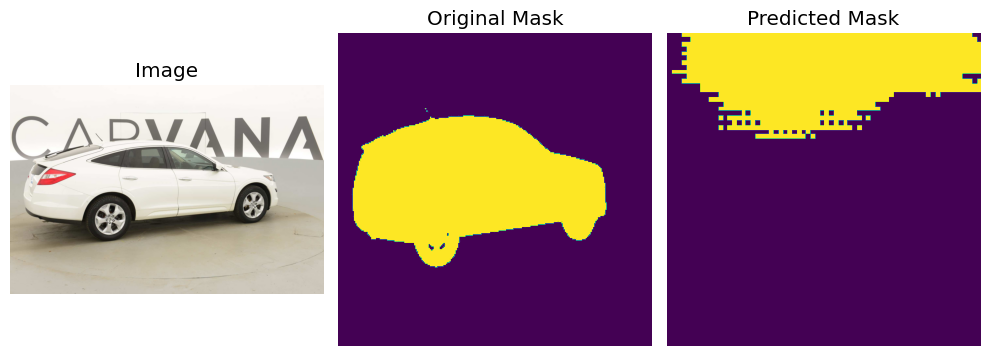

In [47]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
for filename in glob.glob(TEST_PATH + "/*.jpg"):
	# make predictions and visualize the results
	plot_predictions(unet, filename)

## Simple Blob Detector

In [165]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = 1
params.blobColor = 255

# # Change thresholds
# params.minThreshold = 10;
# params.maxThreshold = 200;
#
# Filter by Area.
params.filterByArea = True
params.minArea = 150
#
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.6
#
# # # Filter by Convexity
# # params.filterByConvexity = True
# # params.minConvexity = 0.87
#
# # Filter by Inertia
# params.filterByInertia = True
# params.minInertiaRatio = 0.01

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
  detector = cv2.SimpleBlobDetector(params)
else :
  detector = cv2.SimpleBlobDetector_create(params)

In [166]:
detector

< cv2.SimpleBlobDetector 0000023A5FB951D0>

In [168]:
image_path = "masks/train_masks/com-lam-tradycyjne-wietnamskie-jedzenie.png"

im = cv2.imread(image_path, 0)

In [160]:
cv2.imshow("Image mask", im)
cv2.waitKey(0)

-1

In [177]:
def detect_blobs(image):
	keypoints = detector.detect(image)
	# Draw detected blobs as red circles.
	# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
	im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

	# Show keypoints
	plt.imshow(im_with_keypoints)
	plt.axis("off")
	plt.show()
	return len(keypoints)

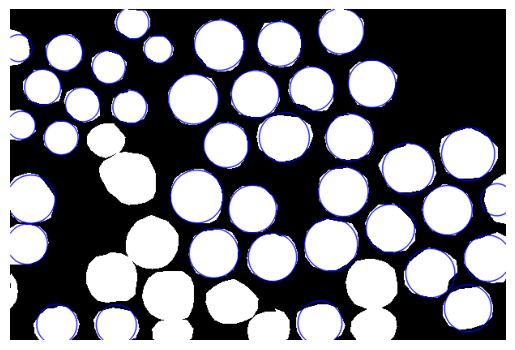

39

In [178]:
detect_blobs(im)

In [172]:
# Detect blobs.
keypoints = detector.detect(im)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)

-1

In [171]:
len(keypoints)

39